In [97]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

**Dataset**


In [98]:
data=pd.read_csv(r'C:\Users\messa\Desktop\MIV\Fouille_donn\weather.nominal.csv',header=None)

In [99]:
data.columns=['outlook','temperature','humidity','windy','play']

In [100]:
data

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


**Support**

In [101]:
data

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [102]:

def support(transactions , min_support):
  itemset=set([item for sublist in transactions for item in sublist])
  count_items={}
  for item in itemset :
    count=0
    for transaction in transactions :
      set_t=set(transaction)
      if item in transaction :
        count+=1
        
    support = count/len(transactions)
    #filter items that have support > min_support
    if min_support <= support and support!=1:
      count_items[item]=support
  count_items=pd.DataFrame.from_dict(count_items,orient='index')
  return count_items


In [103]:
import itertools

def create_itemsets(items,k):
  # items=support.index
  perm_set = itertools.combinations(items,k)
  return set(perm_set)

In [104]:
def support_itemsets(transactions , itemsets , min_support):
  count_items={}
  for item in itemsets :
    count=0
    i_set=set(item)
    for transaction in transactions :
      t_set=set(transaction)
      if t_set.intersection(i_set)==i_set :
        count+=1
    support = count/len(transactions)
    #filter items that have support > min_support
    if min_support <= support and support!=1:
       count_items[item]=support
  count_items=pd.DataFrame.from_dict(count_items,orient='index')
  return count_items

**Apriori**

In [105]:
def apriori(df,min_support):
  transactions_new = data.copy()
  for c in transactions_new .columns:
      transactions_new[c]=str(c)+"="+transactions_new[c].apply(str)
  transactions=transactions_new.to_numpy()
  item_sep=support(transactions,min_support)
  #min sup >0 a faire
  k=2
  itemset=item_sep.index
  df=pd.DataFrame()
  while len(item_sep)!=0:
    itemsets=create_itemsets(itemset,k)
    item_sep=support_itemsets(transactions,itemsets,min_support)
    print(item_sep,k)

    if not item_sep.empty:
        itemset=list()
        for i in item_sep.index:
         for g in i:
            itemset.append(g)
        itemset=set(itemset)
    k+=1
  
  it=len(itemset)+1
  for i in range(1,it):
    itemsets=create_itemsets(itemset,i)
    item_sep=support_itemsets(transactions,itemsets,min_support)
    df=pd.concat([item_sep,df])
  df=df.reset_index()
  df.columns=["itemsets","support"]
 
  return df,itemset


In [106]:
dk,ifreq_items=apriori(data,0.4)

                                    0
(play=yes, humidity=normal)  0.428571
(play=yes, windy=False)      0.428571 2
Empty DataFrame
Columns: []
Index: [] 3


In [107]:
l=[]
for k in dk.itemsets.to_list():
   l.append(set(k))
dk.itemsets=l

In [108]:
dk

,itemsets,support
0,"{windy=False, play=yes}",0.428571
1,"{humidity=normal, play=yes}",0.428571
2,{humidity=normal},0.500000
3,{play=yes},0.642857
4,{windy=False},0.571429


In [109]:
ifreq_items

{'humidity=normal', 'play=yes', 'windy=False'}

Association Rules

In [110]:
def  Association_Rules(dd,apriori_output,threshold=1,metric='confidence'):
    result=pd.DataFrame(columns=['cause','consequence','confidence','lift'])
    perm_set = itertools.permutations(apriori_output,2)
    l=[]
    for j in perm_set:
        l.append(tuple(j))
    np_avant=[]
    np_apres=[]
    conf=[]
    lift=[]
    perm=l
    for p in perm:
        taille=len(p)-1
        while taille>0:
            if (dd['itemsets']==set(p)).any():
                c1=dd[dd['itemsets']==set(p)].support.values/dd[dd['itemsets']==set(p[-taille:])].support.values
                l1=float(c1)/dd[dd['itemsets']==set(p[:-taille])].support.values
                np_avant.append(set(p[-taille:]))
                np_apres.append(set(p[:-taille]))
                conf.append(c1)
                lift.append((l1))
            taille-=1
    result.cause=np_avant
    result.consequence=np_apres
    result.confidence=conf
    result.lift=lift
    if metric=="confidence":
     return result.sort_values(by="confidence")
    else:
       return result.sort_values(by="lift")


In [111]:
Association_Rules(dk,ifreq_items,threshold=1,metric='confidence')

,cause,consequence,confidence,lift
0,{play=yes},{windy=False},[0.6666666666666666],[1.1666666666666667]
1,{play=yes},{humidity=normal},[0.6666666666666666],[1.3333333333333333]
2,{windy=False},{play=yes},[0.75],[1.1666666666666665]
3,{humidity=normal},{play=yes},[0.8571428571428571],[1.3333333333333333]


Ameioration


In [112]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [113]:
encoder=LabelEncoder()
transactions =pd.DataFrame()
for c in data.columns:
    transactions[c]=encoder.fit_transform(data[c])

In [114]:
transactions

,outlook,temperature,humidity,windy,play
0,2,1,0,0,0
1,2,1,0,1,0
2,0,1,0,0,1
3,1,2,0,0,1
4,1,0,1,0,1
5,1,0,1,1,0
6,0,0,1,1,1
7,2,2,0,0,0
8,2,0,1,0,1
9,1,2,1,0,1


In [115]:
import numpy as np
# turn data to numerical value
encoder=LabelEncoder()
tr =pd.DataFrame()
for c in data.columns:
    tr[c]=encoder.fit_transform(data[c])
numerical_transactions = tr.to_numpy()

In [116]:
#choisir le best k-cluster avec elbow methode 
sum_of_squared_distances=[]
K=range(1,15)
for k in K:
    km=KMeans(n_clusters=k,n_init=5).fit(numerical_transactions)
    sum_of_squared_distances.append(km.inertia_)

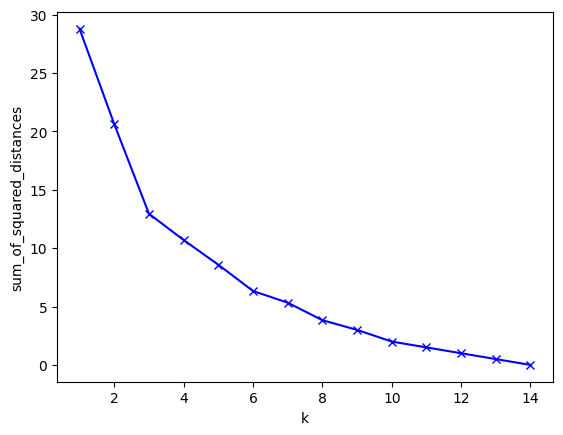

In [117]:
plt.plot(K,sum_of_squared_distances,'bx-')
plt.xlabel('k')
plt.ylabel("sum_of_squared_distances")
plt.show()

In [118]:
kmeans = KMeans(n_clusters=3,n_init=5, random_state=0).fit(numerical_transactions)
labels = kmeans.labels_

# Calculer la moyenne des support dans chaque cluster 
cluster_support = {}
for i in range(len(transactions)):
    if labels[i] not in cluster_support:
        cluster_support[labels[i]] = []
    cluster_support[labels[i]].append(np.mean(numerical_transactions[i]))

#utiliser le mean de tout les cluster comme meuillerur seuil
min_support = np.mean([np.mean(cluster_support[c]) for c in cluster_support])

print("Minimum support threshold:", min_support)

Minimum support threshold: 0.75


CLOSE

In [119]:
transactions = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans' ,'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'], 
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans','Yogurt'],
           ['corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

In [120]:
def support_items(transactions , min_support):
      count_items={}
      itemsets=set([item for sublist in transactions for item in sublist])
      for item in itemsets:
        itemset = frozenset([item])
        support = sum(1 for transaction in transactions if itemset.issubset(transaction)) / len(transactions)
        
        if support >= min_support:
            count_items[itemset] = support
      return  count_items

In [121]:
def create_itemsets(closed_frequent_itemsets,k):
  itemsets = set(frozenset.union(itemset1, itemset2) for itemset1 in closed_frequent_itemsets for itemset2 in closed_frequent_itemsets if len(itemset1.union(itemset2)) == k)


  return itemsets

In [122]:
def support_iteamset(transactions,itemsets,min_support):
        frequent_itemsets_k = {}
        taille = len(transactions)
        for itemset in itemsets:
            support = sum(1 for transaction in transactions if itemset.issubset(transaction)) / taille
            if support >= min_support:
                frequent_itemsets_k[itemset] = support
        return frequent_itemsets_k

In [123]:
def Remove(frequent_itemsets):
   reduced ={}
   for itemset1 in frequent_itemsets:
            redundant = False
            for itemset2 in frequent_itemsets:
                if itemset1 != itemset2 and itemset1.issubset(itemset2) and frequent_itemsets[itemset1] == frequent_itemsets[itemset2]:
                    redundant = True
                    break
            if not redundant:
                reduced[itemset1] = frequent_itemsets[itemset1]
   return reduced

In [124]:
def close(transactions, min_support):

    
    closed_frequent_itemsets = support_items(transactions , min_support)
  
    k = 2
    while True:
        itemsets = create_itemsets(closed_frequent_itemsets,k)
        if len(itemsets) == 0:
            break
        
        frequent_itemsets = support_iteamset(transactions ,itemsets, min_support)
        if len(frequent_itemsets) == 0:
            break
        
        frequent_itemsets_reduced = Remove(frequent_itemsets)


        closed_frequent_itemsets.update(frequent_itemsets_reduced)
        
        k += 1
    
    return closed_frequent_itemsets

In [125]:
close(transactions, 0.5)

{frozenset({'Kidney Beans'}): 1.0,
 frozenset({'Yogurt'}): 0.6,
 frozenset({'Onion'}): 0.6,
 frozenset({'Milk'}): 0.6,
 frozenset({'Eggs'}): 0.8,
 frozenset({'Eggs', 'Kidney Beans'}): 0.8,
 frozenset({'Kidney Beans', 'Onion'}): 0.6,
 frozenset({'Kidney Beans', 'Yogurt'}): 0.6,
 frozenset({'Eggs', 'Onion'}): 0.6,
 frozenset({'Kidney Beans', 'Milk'}): 0.6,
 frozenset({'Eggs', 'Kidney Beans', 'Onion'}): 0.6}